# Deep Learning from Scratch With Python

This post describes the steps involved in deep learning, with a practical example, written in Python.  The code creates a multi layer neural network with logistic regression. This system will be trained with a set of images of handwritten digits and then be tested with a different set of images to see if it can identify the digits.

This is not a complete guide to Machine Learning or Deep Learning, but just one example, offered without rigorous proof of the equations used. If you're looking for a course on the subject, [Andrew Ng's Machine Learning course on Coursera](https://www.coursera.org/learn/machine-learning) would be a very good and popular choice.

The 4 layers of this example neural network are:
 
1. Input layer of 256 inputs
1. Hidden layer of 30 nodes
1. Hidden layer of 20 nodes
1. Output layer of 10 outputs

"nodes" and "layers" are merely names used to conceptualize the mathematics.  In the code, the numbers of layers and nodes simply translate to the sizes of the weights arrays. These arrays store the "learned" information of the system.

There are some great machine learning/deep learning libraries for Python, such as [scikit-learn](http://scikit-learn.org/stable/), [TensorFlow](https://www.tensorflow.org) and [Theano](http://deeplearning.net/software/theano/).  To better illustrate deep learning, we are not going to use these libraries, but instead code the system from scratch. 

The only Python libraries needed are numpy for matrix manipulation, matplotlib for plotting the data, random to initiate the weights, and urllib to pull down the data from a URL:

In [1]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import urllib

### Sigmoid Function

The sigmoid function outputs a value between zero and one from an input between $-\infty$ and $\infty$. It is used to take an input and turn it into an activation value for a "neuron". or node.

$ h_\theta (x) = g(\theta^T x) = g(z) = \dfrac{1}{1 + e^{-z}} = \dfrac{1}{1 + e^{-\theta^T x}}$

In [2]:
def sigmoid(z):
    return 1.0 /(1.0 + np.exp(-z))

### Partial Derivative of the Sigmoid Function

Later, we use gradient decent to make corrections to the weights. This is how the system learns. "_Gradient_ decent" suggests differentials, and indeed, we will need the partial differential of the sigmoid function:

$ \dfrac{dg(z)}{dz} = g(z) (1 - g(z))$

In [3]:
def sigmoidDerivative(z):
  return sigmoid(z) * (1 - sigmoid(z));

The system uses "weights" to determine the influence of each activation value on the output of each neuron.  It is these weights which are altered during the learning phases.  To start with, these will be initialized to random values.  If we initialized the weights to zero, the system would not be able to form suitable differentials between the neurons.

This function creates a 2D array of random weights, $w$ where $ -1 \le w_{ij} \le 1 $

In [4]:
def initWeights(numInputs,numOutputs):
    return 2 * np.random.random((numInputs,numOutputs)) - 1

"Bias terms" are used to add extra weighing to the inputs.  Think of these as the intercept point of the linear equations.

This function prepends a column of ones to an array for adding bias terms to inputs.

In [5]:
def addOnes(arr):
    ones = np.ones((arr.shape[0],1))
    return  np.insert(arr,[0],ones,axis=1)

This function prepends a column of zeros to an array. This is to remove the influence of the bias term weights later on for regularization.

In [6]:
def addZeros(arr):
    zeros = np.zeros((arr.shape[0],1))
    return  np.insert(arr,[0],zeros,axis=1)

Our system is designed to predict boolean outputs of either zero or one.  However, the sigmoid function outputs a number somewhere between zero and one. This output is the probability that Y is one, so we simply return one if the sigmoid function output is greater than half, otherwise we return zero.

In [7]:
def convertOutputs(outputs):
    return (outputs > 0.5).astype(int)

### Prediction

The "predict" function uses the weighted terms and inputs to predict outputs for each layer in the neural network.

For each layer:

$ h_\theta (x) = g(\theta X)$

where:
* $g$ is the sigmoid function
* $h_\theta$ is the hypothesis function (output) for each layer
* $x$ are the inputs on each neuron
* $\theta$ are the weights

Output:

* list of activations per layer (for every sample)
* weighted outputs per layer (for every sample)
* last layer outputs (per sample)

In [8]:
# X is an array of inputs per sample
# thetas is a list of 2D weights for each layer
def predict(X,thetas):
    
    activations       = []  # net inputs on each neuron per layer
    weighted_outputs  = [] # weighted outputs from each neuron per layer
    
    a = X # First set of activations are the inputs
    
    for theta in thetas:
        a_bias = addOnes(a)      # add bias terms to activations
        activations.append(a_bias)
        
        z = a_bias.dot(theta.T)  # add weights to each activation per neuron
        weighted_outputs.append(z)
        
        a = sigmoid(z)           # h(x) out of each neuron in the layer (also the activations for next layer)
    

    outputs = a # final outputs
    
    return (activations,weighted_outputs,outputs)
    

### Cost Function for Regularized Logistic Regression

The learning algorithm seeks to minimize this cost function.

$ J(\theta) = - \dfrac{1}{m} \sum\limits_{i=1}^{m} \sum\limits_{j=1}^{J} [t_i \ log(h_\theta(x_{ij})) + (1 - t_{ij}) \ log(1-h_\theta(x_{ij}))] + \dfrac{\lambda}{2m} \sum\limits_{k=1}^{K} \theta_{k}^2 $

Where:
* $\theta$ are the weight terms
* $m$ is the number of training examples
* $J$ is the number of output nodes
* $K$ is the number of weight terms across all nodes (not including the bias values)
* $\lambda$ is the regularization parameter
* $t$ is the target output
* $h(\theta)$ is the predicted output, or hypothesis function


In [9]:
# X is a 2D array of inputs for each sample
# ideal is a 2D array of ideal values for each sample
# lambd is the regularizaion parameter
# thetas is a list of 2d arrays of theta, starting at the "input -> first layer" theta
def cost(X,ideal,lambd,thetas):
    
    (activations,weighted_outputs,predicted) = predict(X,thetas)

    m = ideal.shape[0] # Numer of samples
    
    J = (1/m) *  sum(sum(  (-ideal * np.log(predicted) - (1 - ideal) * np.log(1-predicted)) ));
        
    # Sum all the theta values together, except the regularized terms
    sumThetas = 0
    for theta in thetas:
        sumThetas += sum(sum( theta[:,1:] * theta[:,1:] ))
        
    # Regularised cost function 
    r = (lambd/(2*m)) * (sumThetas);
    
    return J + r

### Backpropagation

The _grads_ function returns the gradients of the cost function by "backpropagation". First the forward pass is run (using the "predict" function). This computes all the activation terms, for all nodes in the network.

Then the gradients of the error terms are calculated and summed over all the training samples. The code shows different calculations for output layers (where the target output value is known), and the hidden layers (where the target value has to propagate down from the output layer).

The gradient of the cost function (the return value of this function) is then calculated as:

$\dfrac {\partial}{\partial \theta}  J(\theta) = \dfrac{1}{m} \Delta $ for the output layer

$\dfrac {\partial}{\partial \theta}  J(\theta) = \dfrac{1}{m} \Delta  + \dfrac{\lambda}{m} \theta$ for the hidden layers

For each neuron
Where:
* $m$ is the number of data samples
* $\lambda$ is the regularization parameter
* $\Delta$ are the accumulated gradients (for all test samples)



In [10]:
def grads(X,Y,lambd,thetas):
    
    m = X.shape[0]
    Xb =  addOnes(X)
    deltas = []
    
    # Init the deltas
    for theta in thetas:
        deltas.append(np.zeros(theta.shape))
    
    # Make predictions
    (activations,weighted_outputs,outputs) = predict(X,thetas)
    
    # Backpropogation
    for t in range(0,m): # for every data row

        # Output layer
        deltaOut = np.array([(outputs[t] - Y[t,:])])
        deltas[-1] = deltas[-1] + deltaOut.T.dot(np.array([ activations[-1][t] ]))
        
        # Work backwards through hidden layers
        dLast = deltaOut
        for layer in range(len(deltas) -2,-1,-1):
            
            a = np.array([ activations[layer][t] ])
            z = np.array([ weighted_outputs[layer][t] ])    
            d = (thetas[layer + 1].T.dot(dLast.T))[1:].T * sigmoidDerivative(z);
            deltas[layer] = deltas[layer] + d.T.dot(a)
            
            dLast = d
    
    return [ (1/m)*deltas[i] + (lambd/m) * addZeros(thetas[i][:,1:]) for i in range(0,len(deltas)) ]


### The Data

The data source is a selection of [1593 handwritten digits](https://archive.ics.uci.edu/ml/machine-learning-databases/semeion/semeion.names).  The data consists of rows of digit data with each row containing a 16x16 pixel image (the first 256 columns), followed by 10 digits of ones and zeros, representing the Y value.

Y values are stored as ten columns of data. "1" in the first column signifies zero, a "1" in the second signifies two and so on.

In [11]:
def ansToDigit(y):
    ans = (y > 0.5).astype(int)
    for i in range(10):
        if ans[i] == 1: return i
    return 0

The data is extracted from the given URL. It is then split into Dev and Test data. The Dev data being used for training, while the Test data is used to check the results of the training.

In [12]:
# data description:
# https://archive.ics.uci.edu/ml/machine-learning-databases/semeion/semeion.names
dataSource = (
  'https://archive.ics.uci.edu/ml/machine-learning-databases/semeion/semeion.data'
)
data = np.loadtxt(urllib.request.urlopen(dataSource).readlines())
X = data[:,0:256].astype(int)
Y = data[:,256:].astype(int)
print("X data:",X.shape)
print("Y data:",Y.shape)


# Shuffle the values
XShuffled = []
YShuffled = []
indexes = np.random.permutation(len(Y))

for i in indexes:
    XShuffled.append(X[i])
    YShuffled.append(Y[i])

# Use most for dev and 100 for test
XDev  = np.array(XShuffled[0:-100])
YDev  = np.array(YShuffled[0:-100])
XTest = np.array(XShuffled[-100:])
YTest = np.array(YShuffled[-100:])


X data: (1593, 256)
Y data: (1593, 10)


### System Initialization

Initial values of $\theta$ (the weights) are set. The input layer is of a known size (the 256 pixels of the images), as is the output layer (10 outputs representing the output number).  However the number of hidden layers and the nodes per hidden layer can be of any size we choose. One hidden layer is usually acceptable for such a case, however two hidden layers are used here, by way of an example. The only representation of these sizes in the code is in the size of these weights arrays (theta1, theta2, etc), which can be changed as required.

In [13]:
# Seed weights with random numbers
np.random.seed(1)
hiddenLayer1Size = 30
hiddenLayer2Size = 20

theta1   = initWeights(hiddenLayer1Size,XDev.shape[1]+1)   # between input and hidden layer
theta2   = initWeights(hiddenLayer2Size,hiddenLayer1Size+1) # between hidden layer and output
theta3   = initWeights(Y.shape[1],hiddenLayer2Size+1) # between hidden layer and output
thetas   = [ theta1,theta2,theta3 ]


### The Learning Phase

The code below puts the training (Dev data) dataset through the learning algorithm, updates the weights, then tests its performance using the testing dataset.  It loops through this process 300 times, which is enough to bring the performance of the tests to an acceptable level.

The weights are updated by simply subtracting the error gradients.  More complex algorithms are available which can improve the efficiency here.

In [14]:
# Try out the cost function

lambd = 0.1
devCosts = []

testAccuracies = []

for i in range(0,300):
    J = cost(XDev,YDev,lambd,thetas)
    (theta1Grad,theta2Grad,theta3Grad) = grads(XDev,YDev,lambd,thetas)
    if i % 10 == 0: print('.', end="")
    
    theta1 = theta1 - theta1Grad
    theta2 = theta2 - theta2Grad
    theta3 = theta3 - theta3Grad
    
    thetas = [ theta1,theta2,theta3]
    devCosts.append(J)
    
    
    # Run test against test data
    (activations,weighted_outputs,outputs) = predict(XTest,thetas)
    answers = convertOutputs(outputs)
    right = wrong = 0
    
    for k in range(0,len(outputs)):
        if np.array_equal(np.array(YTest[k]),np.array(answers[k])): right +=1
        else: wrong +=1
    testAccuracies.append(right/(right+wrong))

..............................

Plot of the cost against the number of iterations

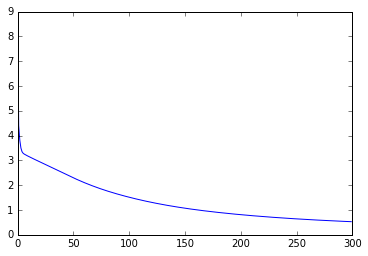

In [15]:
plt.plot(devCosts)
plt.show()

Plot of the accurancy on the test data against the number of iterations

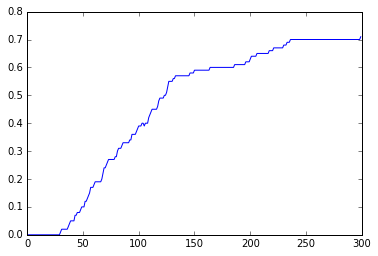

In [16]:
plt.plot(testAccuracies)
plt.show()

### Prediction

Now the weights are set, these values can be used to make predictions. Here, 5 samples are selected from the Test data set and are run through the prediction algorithm.  Note that the prediction of new data is relatively quick.  The hard work has already been done in setting the weights.

Actual:   7
Guess:    7


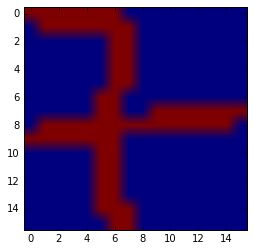

-------------------------------
Actual:   8
Guess:    3


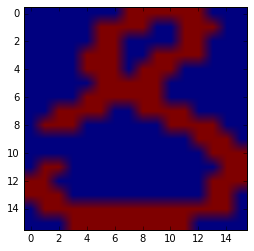

-------------------------------
Actual:   5
Guess:    4


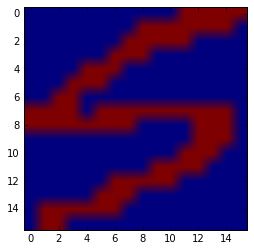

-------------------------------
Actual:   3
Guess:    3


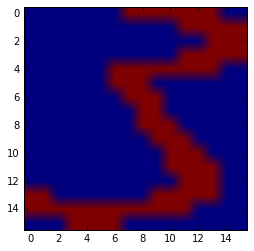

-------------------------------
Actual:   7
Guess:    7


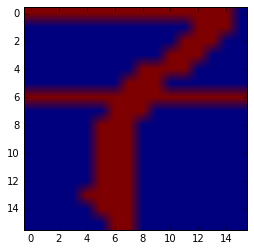

-------------------------------
Right: 3
Wrong: 2
Accuracy: 60%


In [17]:


m = XTest.shape[0]

right = 0
wrong = 0

for t in range(5):
    
    (activations,weighted_outputs,outputs) = predict(np.array([ XTest[t] ]),thetas)
    
    yDigit   = ansToDigit(YTest[t])
    ansDigit = ansToDigit(outputs[0])
    print("Actual:  ",yDigit)
    print("Guess:   ", ansDigit)

    np.array([ XTest[t] ])
    
    plt.imshow(np.array([ XTest[t] ]).reshape(16,16))
    plt.show()
    print("-------------------------------")
    
    if yDigit == ansDigit: right +=1
    else: wrong +=1

print("Right:",right)
print("Wrong:",wrong)
print("Accuracy: %i%%" % (right*100/(right+wrong)) )


## Conclusion

Deep learning code need not be overly long.  Here we have shown an example which is small, yet makes reasonable predictions on hand written digits.

The algorithms used are not specifically for handwriting recognition, so this same code could easily be used for other Deep Learning applications.

For real world applications it may be prudent to use existing libraries which;

* are be better optimized for the given hardware
* have been more thoroughly tested
* contain more complex algorithms for faster gradient decent

## The Code

The complete code and description can be downloaded in the form of a [Jupyter notebook](https://nbviewer.jupyter.org/github/douglas-gibbons/douglas-gibbons.github.io/tree/master/notebooks/Deep%20Learning%20from%20Scratch%20With%20Python.ipynb)